# 0. Initialized project

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv
/kaggle/input/homecredit-feature-group/pcb_info_conso.parquet
/kaggle/input/homecredit-feature-group/main_df.parquet
/kaggle/input/homecredit-feature-group/HomeCredit_feature_group.xlsx


In [9]:
import sklearn
# import statsmodels
# import optbinning
# import mlxtend

from tqdm import tqdm

import lightgbm
# import xgboost

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_colwidth', None)

In [10]:
"""
/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv
"""

'\n/kaggle/input/home-credit-default-risk/sample_submission.csv\n/kaggle/input/home-credit-default-risk/bureau_balance.csv\n/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv\n/kaggle/input/home-credit-default-risk/application_train.csv\n/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv\n/kaggle/input/home-credit-default-risk/application_test.csv\n/kaggle/input/home-credit-default-risk/previous_application.csv\n/kaggle/input/home-credit-default-risk/credit_card_balance.csv\n/kaggle/input/home-credit-default-risk/installments_payments.csv\n/kaggle/input/home-credit-default-risk/bureau.csv\n'

In [11]:
os.chdir('/kaggle/input/homecredit-feature-group')
feature_group = pd.read_excel('HomeCredit_feature_group.xlsx')

In [13]:
os.chdir('/kaggle/input/home-credit-default-risk')
#sample
sample_submission = pd.read_csv('sample_submission.csv', encoding='utf-8')
#bureau info
bureau = pd.read_csv('bureau.csv', encoding='utf-8')
bureau_balance = pd.read_csv('bureau_balance.csv', encoding='utf-8')
#main info
application_train = pd.read_csv('application_train.csv', encoding='utf-8')
application_test = pd.read_csv('application_test.csv', encoding='utf-8')
#past info
previous_application = pd.read_csv('previous_application.csv', encoding='utf-8')
#balance
pos_cash_balance = pd.read_csv('POS_CASH_balance.csv', encoding='utf-8')
#card info
credit_card_balance = pd.read_csv('credit_card_balance.csv', encoding='utf-8')
#payment info
installments_payments = pd.read_csv('installments_payments.csv', encoding='utf-8')

In [14]:
id_col = list(feature_group[feature_group['GROUP'].isin(['ID', 'LABEL'])]['Row'].unique())
feature_col = list(feature_group[~feature_group['GROUP'].isin(['ID', 'LABEL'])]['Row'].unique())

# 1. Exploratory data analysis

In [7]:
feature_group['GROUP'].value_counts()

GROUP
Credit info       65
Housing           55
Demo              31
Credit balance    18
POS               15
ID                13
Overdue            7
Enquiries          6
Credit score       3
Credit Info        2
Payment            2
LABEL              1
Income             1
Name: count, dtype: int64

In [7]:
id_col = list(feature_group[feature_group['GROUP'].isin(['ID', 'LABEL'])]['Row'].unique())
feature_col = list(feature_group[~feature_group['GROUP'].isin(['ID', 'LABEL'])]['Row'].unique())

In [ ]:
application_train.head(10)

In [ ]:
application_train.NAME_CONTRACT_TYPE.value_counts().index

In [ ]:
application_train[['NAME_FAMILY_STATUS','TARGET']].groupby(['NAME_FAMILY_STATUS'], as_index=False).mean()

In [ ]:
application_train[['NAME_FAMILY_STATUS']].value_counts()

In [ ]:
application_train[['NAME_FAMILY_STATUS','TARGET']].groupby(['NAME_FAMILY_STATUS']).mean()

In [ ]:
application_train[['NAME_FAMILY_STATUS','FONDKAPREMONT_MODE','TARGET']].value_counts()

In [ ]:
application_train[['NAME_FAMILY_STATUS', 'FONDKAPREMONT_MODE','TARGET']]

In [ ]:
application_train.pivot_table(values='TARGET',
                  columns=['NAME_FAMILY_STATUS'],
                  aggfunc=['count'],
                  dropna=False,
         index=['FONDKAPREMONT_MODE'])

In [ ]:
application_train.pivot_table(values='TARGET',
                  aggfunc=['sum', 'count', 'mean'],
                  dropna=False,
         index=['NAME_FAMILY_STATUS'])

In [9]:
def plot_stats(feature:str, label:str, df, horizontal_layout, label_rotation):
    #prepare data
    temp_count = df[feature].value_counts()
    df_count = pd.DataFrame({feature:temp_count.index, 'No contracts':temp_count.values})
    df_perc = df[[feature, label]].groupby([feature], as_index=False).mean()
    df_perc.sort_values(by=label, ascending=False, inplace=True)
    
    #initialize subplot
    #horizontal layout
    if horizontal_layout:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,14))
    sns.set_color_codes('pastel')
    s1 = sns.barplot(ax=ax1, x=feature, y='No contracts', order=df_perc[feature], data=df_count)
    s2 = sns.barplot(ax=ax2, x=feature, y=label, order=df_perc[feature], data=df_perc)
    
    #tickmark flip
    if label_rotation:
        s1.set_xticklabels(s1.get_xticklabels(), rotation=90)
        s2.set_xticklabels(s2.get_xticklabels(), rotation=90)
    
    #set up chart
    plt.ylabel('Percent of target with 1', fontsize=10)
#     plt.tick_params(axis='both', which='major', labelsize=10)
    plt.show()

In [10]:
def plot_distribution(df, feature, bins=100):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s"%feature)
    sns.histplot(df[feature].dropna(), color='green', kde=True, bins=bins)
    plt.show()

In [11]:
def plot_distribution_target(df, feature_list, label, nrows=3):
    #data
    t1 = df.loc[df[label] != 0]
    t0 = df.loc[df[label] == 0]
    #get frame
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 6*nrows))
    
    i=0
    for feature in feature_list:
        i += 1
        plt.subplot(nrows,2,i)
        sns.kdeplot(t1[feature], bw_method=0.01, label='TARGET [1]')
        sns.kdeplot(t0[feature], bw_method=0.01, label='TARGET [0]')
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=10)
    plt.legend()
    plt.show()

In [ ]:
plot_stats('FONDKAPREMONT_MODE','TARGET', application_train, True, True)

In [ ]:
plot_stats('OCCUPATION_TYPE','TARGET', application_train, True, True)

In [ ]:
for i in range(2,22):
    plot_stats(f'FLAG_DOCUMENT_{i}','TARGET', application_train, True, True)

In [ ]:
application_train.info(verbose=True)

In [ ]:
plot_distribution(application_train, 'AMT_CREDIT', bins=30)

In [ ]:
feature_list = ['AMT_REQ_CREDIT_BUREAU_YEAR','CNT_CHILDREN',
                'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
                'AMT_INCOME_TOTAL','AMT_REQ_CREDIT_BUREAU_YEAR',
                'LIVINGAPARTMENTS_AVG'
               ]
plot_distribution_target(application_train, feature_list, 'TARGET', nrows=4)

In [ ]:
id_list = feature_group[feature_group['GROUP'].isin(['ID','LABEL'])]['Row']
feature_list = list(set(feature_group['Row']) - set(id_list))

In [ ]:
len(feature_list)

In [ ]:
plot_distribution(bureau, 'AMT_ANNUITY', bins=30)

In [ ]:
plot_distribution(bureau, 'AMT_CREDIT_SUM_LIMIT', bins=30)

In [ ]:
bureau_balance.head()

In [ ]:
bureau_balance['STATUS'].value_counts()

In [ ]:
pos_cash_balance.head()

In [ ]:
application_train.info(verbose=True, show_counts=True)

In [ ]:
application_train['FLAG_DOCUMENT_10'].isna().sum()

In [ ]:
filter1_comp['app']

# 2 Feature engineering

In [ ]:
# os.chdir('/kaggle/working')

## main feature - income, credit

In [15]:
def distinct_count(df):
    most_count_lst = {'col':[],'most_count':[], 'null_count':[]}
    total_count = len(df)
    for col in df.columns:
        most_count = df[col].value_counts(sort=True, dropna=False).iloc[0]
        null_count = df[col].isna().sum()
        
        cover_pct = most_count/total_count
        null_pct = null_count/total_count
        
        most_count_lst['col'].append(col)
        most_count_lst['most_count'].append(cover_pct)
        most_count_lst['null_count'].append(null_pct)
    
    return pd.DataFrame(most_count_lst)

df_list = [application_train, previous_application, pos_cash_balance, credit_card_balance, installments_payments, bureau, bureau_balance]
feat_store = ['app', 'prev', 'pos', 'cc', 'inst', 'bu', 'bu_bal']

filter1_comp = {}

for df, st in zip(df_list, feat_store):
    filter1 = distinct_count(df)
    drop_most_count = list(set(filter1[filter1['most_count']>=0.8]['col'])-set(id_col))
    drop_most_null = list(set(filter1[filter1['null_count']>=0.6]['col'])-set(id_col))
    filter1_comp[st] = drop_most_count + drop_most_null
    print(st)

app
prev
pos
cc
inst
bu
bu_bal


In [16]:
# id_col = list(feature_group[feature_group['GROUP'].isin(['ID', 'LABEL'])]['Row'].unique())
# feature_col = list(feature_group[~feature_group['GROUP'].isin(['ID', 'LABEL'])]['Row'].unique())

In [17]:
filter1_comp['bu']

['CREDIT_DAY_OVERDUE',
 'CREDIT_CURRENCY',
 'CNT_CREDIT_PROLONG',
 'AMT_CREDIT_SUM_OVERDUE',
 'AMT_ANNUITY',
 'AMT_CREDIT_MAX_OVERDUE']

In [18]:
id_col

['SK_ID_CURR', 'TARGET', 'SK_BUREAU_ID', 'SK_ID_PREV ', 'NAME_CONTRACT_TYPE']

In [19]:
### PROCESS ###
def application_feature(df):
    df['AGE'] = round(df['DAYS_BIRTH']*-1/365,0)
    df['YEAR_WORKING'] = round(df['DAYS_EMPLOYED']*-1/365,0)
    df['inc_ovr_credit'] = df['AMT_INCOME_TOTAL']/df['AMT_CREDIT']
    df['inc_ovr_annuity'] = df['AMT_INCOME_TOTAL']/df['AMT_ANNUITY']
    df['inc_ovr_good'] = df['AMT_INCOME_TOTAL']/df['AMT_GOODS_PRICE']
    return df

In [20]:
application_train = (
    application_train.pipe(application_feature)
    )

<Axes: >

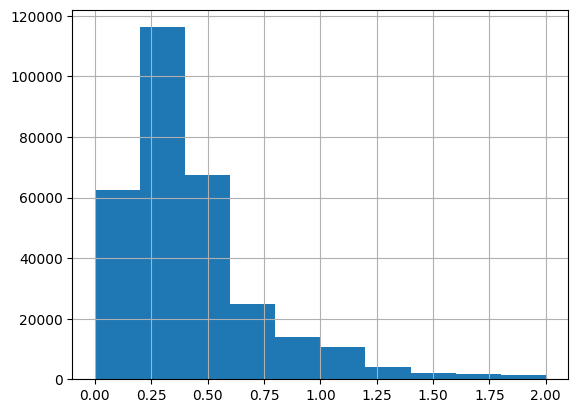

In [21]:
application_train['inc_ovr_good'].hist(range=(0,2))

## TS dpd, loan_term

In [22]:
from functools import reduce

def time_travel(df, mth):
    """
    DAYS_CREDIT --> LxM
    """
    filter_time = (df['LxM']*-1) <= mth
    return df[filter_time]
   
# customer function
def q20(x):
    return x.quantile(0.2)

def q80(x):
    return x.quantile(0.8)

def average(x, mth_counts):
    """
    x = pd.Series
    """
    return x.sum()/mth_counts

    
def agg_cal(input_df:pd.DataFrame, 
            group_col:list, 
            val:str,
            agg_fn:list,
           ):    
    
    group_df = input_df[[val]+group_col].groupby(group_col, dropna=False)
    
    df = group_df.agg({val:agg_fn})
    df.columns = agg_fn
    all_func = agg_fn
    function_name = [fn.__name__ if callable(fn) else fn for fn in agg_fn]
    rename_cols = [val+'_'+F for F in (function_name)]
    df.columns = rename_cols
    
    return df


def generate_feature_lxm(df, 
                         group_col:list, 
                         val_col:list, 
                         agg_fn:list,  
                         LxM:list):
    """
        required columns: ['LxM']
    """
    result_lst = []
    for val in tqdm(val_col):
        for mth_counts in LxM: 
            df_lxm = time_travel(df, mth_counts)
            result = agg_cal(df_lxm, group_col, val, agg_fn)
            result.columns = [col+f'_l{mth_counts}m' for col in result.columns]
            result_lst.append(result)
        
    final_df = reduce(lambda  left,right: pd.merge(left, right, on=group_col, how='outer'), result_lst)
    return final_df

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
df_pcb = bureau[bureau['SK_ID_CURR'].isin(application_train['SK_ID_CURR'].unique())]
df_pcb['LxM'] = df_pcb['DAYS_CREDIT']/30.5
df_pcb['loan_term'] = df_pcb['AMT_CREDIT_SUM']/df_pcb['AMT_ANNUITY']

In [ ]:
len(application_train)

## TS bureau - amt, limit, term

In [ ]:
len(df_pcb)

In [ ]:
df_pcb['CREDIT_ACTIVE'].value_counts()

In [14]:
def pcb_ts_info(df_pcb):
    active = df_pcb['CREDIT_ACTIVE']=='Active'
    close = df_pcb['CREDIT_ACTIVE']=='Closed'
    df_active = df_pcb[active]
    df_close = df_pcb[close]

    group_col = ['SK_ID_CURR']
    val_col = ['AMT_CREDIT_SUM','AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_DEBT', 'loan_term']
    agg_fn = ['mean','min','max','sum','count', 'std', 'var']
    LxM = [3,6,9,12,15,24,36]

    pcb_ts_all = generate_feature_lxm(df_pcb, group_col, val_col, agg_fn, LxM)
    pcb_ts_active = generate_feature_lxm(df_active, group_col, val_col, agg_fn, LxM)
    pcb_ts_closed = generate_feature_lxm(df_close, group_col, val_col, agg_fn, LxM)

    pcb_ts_active.columns = [col+'_active' for col in pcb_ts_active.columns]
    pcb_ts_closed.columns = [col+'_close' for col in pcb_ts_closed.columns]
    
    result_lst = [pcb_ts_all, pcb_ts_active, pcb_ts_closed]
    
    final_df = reduce(lambda  left,right: pd.merge(left, right, on=group_col, how='outer'), result_lst)
    return final_df

In [ ]:
pcb_ts_total = pcb_ts_info(df_pcb)

In [ ]:
prod_group = ['Consumer credit', 'Credit card', 'Car loan', 'Mortgage']
pcb_ts_prod = {}
for prod in prod_group:
    print(f'Processing {prod}')
    df_prod = df_pcb[df_pcb['CREDIT_TYPE'] == prod].copy()
    pcb_ts_prod[prod] = pcb_ts_info(df_prod)

In [ ]:
rename_prod = ['csm', 'card', 'car', 'mg']

for prod, name in zip(prod_group, rename_prod):
    df_to_rename = pcb_ts_prod[prod]
    df_to_rename.columns = [col+'_'+name for col in df_to_rename.columns] 
    print(prod)

In [ ]:
to_merge = [i.reset_index() for i in pcb_ts_prod.values()]
to_merge.append(pcb_ts_total)

del pcb_ts_prod
del pcb_ts_total

In [ ]:
pcb_info_conso = reduce(lambda  left,right: pd.merge(left, right, on='SK_ID_CURR', how='outer'), to_merge)

In [ ]:
filter1a = distinct_count(pcb_info_conso)
drop_most_count = list(set(filter1a[filter1a['most_count']>=0.8]['col'])-set(id_col))
drop_most_null = list(set(filter1a[filter1a['null_count']>=0.6]['col'])-set(id_col))

In [ ]:
keep = set(pcb_info_conso.columns) - set(drop_most_count + drop_most_null)

In [ ]:
pcb_info_conso_ = pcb_info_conso[list(keep)]
del pcb_info_conso

In [ ]:
application_train.to_parquet(r'main_df.parquet')
pcb_info_conso_.to_parquet(r'pcb_info_conso.parquet')

#### Checkpoint

In [26]:
#Check point
os.chdir(r'/kaggle/input/homecredit-feature-group')
application_train = pd.read_parquet(r'main_df.parquet')
pcb_info_conso_ = pd.read_parquet(r'pcb_info_conso.parquet')

In [27]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE,YEAR_WORKING,inc_ovr_credit,inc_ovr_annuity,inc_ovr_good
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,26.0,2.0,0.498036,8.198215,0.576923
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,3.0,0.208736,7.563343,0.239044
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,None,NaN,None,None,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,1.0,0.500000,10.000000,0.500000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,None,NaN,None,None,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,52.0,8.0,0.431748,4.547522,0.454545
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,None,NaN,None,None,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,8.0,0.236842,5.556699,0.236842


In [28]:
application_train.shape

(307511, 127)

## TS bureau dpd

In [ ]:
df_pcb = bureau[bureau['SK_ID_CURR'].isin(application_train['SK_ID_CURR'].unique())]
df_pcb['LxM'] = df_pcb['DAYS_CREDIT']/30.5
df_pcb['loan_term'] = df_pcb['AMT_CREDIT_SUM']/df_pcb['AMT_ANNUITY']

In [ ]:
condition = (df_pcb['CREDIT_DAY_OVERDUE'] <=10) & (df_pcb['CREDIT_DAY_OVERDUE'] >= 1)
df_pcb['is_1_10dpd'] = np.where(condition, 1, 0)

condition = (df_pcb['CREDIT_DAY_OVERDUE'] <=30) & (df_pcb['CREDIT_DAY_OVERDUE'] >= 10)
df_pcb['is_10_30dpd'] = np.where(condition, 1, 0)

condition = (df_pcb['CREDIT_DAY_OVERDUE'] > 30)
df_pcb['is_gt30dpd'] = np.where(condition, 1, 0)

In [ ]:
def pcb_dpd(df_pcb):
    group_col = ['SK_ID_CURR']
    val_col = ['CREDIT_DAY_OVERDUE', 'is_1_10dpd', 'is_10_30dpd', 'is_gt30dpd']
    agg_fn = ['max']
    LxM = [3,6,9,12,15,24,36, 48,60,72,84]

    pcb_dpd_ts = generate_feature_lxm(df_pcb, group_col, val_col, agg_fn, LxM)
    return pcb_dpd_ts

In [ ]:
df_pcb_dpd = pcb_dpd(df_pcb)
df_pcb_dpd = df_pcb_dpd.fillna(0).reset_index()

In [ ]:
df_pcb['active_mths_remain'] = df_pcb[df_pcb['CREDIT_ACTIVE']=='Active']['DAYS_CREDIT_ENDDATE']/30.5
cond1 = (df_pcb['active_mths_remain']<0)
df_pcb['active_mths_remain'] = np.where(cond1, 0, df_pcb['active_mths_remain'])  
df_pcb['active_mths_remain'] = df_pcb['active_mths_remain'].fillna(0)

In [ ]:
df_pcb['card_utl_rate'] = df_pcb['AMT_CREDIT_SUM_DEBT']/df_pcb['AMT_CREDIT_SUM_LIMIT']
df_pcb['card_utl_rate'] = np.where((df_pcb['CREDIT_TYPE']=='Credit card') & (df_pcb['card_utl_rate']!=np.inf),df_pcb['card_utl_rate'],np.nan)

In [ ]:
df_pcb.head()

In [ ]:
def pcb_credit_info1(df_pcb):
    group_col = ['SK_ID_CURR']
    val_col = ['active_mths_remain', 'card_utl_rate']
    agg_fn = ['mean', 'max']
    LxM = [3,6,9,12,15,24,36, 48,60,72,84]

    ts = generate_feature_lxm(df_pcb, group_col, val_col, agg_fn, LxM)
    return ts

In [87]:
df_pcb_cr1 = pcb_credit_info1(df_pcb)
df_pcb_cr1 = df_pcb_cr1.reset_index()

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.88s/it]


In [89]:
df_pcb_dpd.head()

,SK_ID_CURR,CREDIT_DAY_OVERDUE_max_l3m,CREDIT_DAY_OVERDUE_max_l6m,CREDIT_DAY_OVERDUE_max_l9m,CREDIT_DAY_OVERDUE_max_l12m,CREDIT_DAY_OVERDUE_max_l15m,CREDIT_DAY_OVERDUE_max_l24m,CREDIT_DAY_OVERDUE_max_l36m,CREDIT_DAY_OVERDUE_max_l48m,CREDIT_DAY_OVERDUE_max_l60m,CREDIT_DAY_OVERDUE_max_l72m,CREDIT_DAY_OVERDUE_max_l84m,is_1_10dpd_max_l3m,is_1_10dpd_max_l6m,is_1_10dpd_max_l9m,is_1_10dpd_max_l12m,is_1_10dpd_max_l15m,is_1_10dpd_max_l24m,is_1_10dpd_max_l36m,is_1_10dpd_max_l48m,is_1_10dpd_max_l60m,is_1_10dpd_max_l72m,is_1_10dpd_max_l84m,is_10_30dpd_max_l3m,is_10_30dpd_max_l6m,is_10_30dpd_max_l9m,is_10_30dpd_max_l12m,is_10_30dpd_max_l15m,is_10_30dpd_max_l24m,is_10_30dpd_max_l36m,is_10_30dpd_max_l48m,is_10_30dpd_max_l60m,is_10_30dpd_max_l72m,is_10_30dpd_max_l84m,is_gt30dpd_max_l3m,is_gt30dpd_max_l6m,is_gt30dpd_max_l9m,is_gt30dpd_max_l12m,is_gt30dpd_max_l15m,is_gt30dpd_max_l24m,is_gt30dpd_max_l36m,is_gt30dpd_max_l48m,is_gt30dpd_max_l60m,is_gt30dpd_max_l72m,is_gt30dpd_max_l84m
0,100008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,100020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,100031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,100039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,100041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [88]:
df_pcb_cr1.head()

,SK_ID_CURR,active_mths_remain_mean_l3m,active_mths_remain_max_l3m,active_mths_remain_mean_l6m,active_mths_remain_max_l6m,active_mths_remain_mean_l9m,active_mths_remain_max_l9m,active_mths_remain_mean_l12m,active_mths_remain_max_l12m,active_mths_remain_mean_l15m,active_mths_remain_max_l15m,active_mths_remain_mean_l24m,active_mths_remain_max_l24m,active_mths_remain_mean_l36m,active_mths_remain_max_l36m,active_mths_remain_mean_l48m,active_mths_remain_max_l48m,active_mths_remain_mean_l60m,active_mths_remain_max_l60m,active_mths_remain_mean_l72m,active_mths_remain_max_l72m,active_mths_remain_mean_l84m,active_mths_remain_max_l84m,card_utl_rate_mean_l3m,card_utl_rate_max_l3m,card_utl_rate_mean_l6m,card_utl_rate_max_l6m,card_utl_rate_mean_l9m,card_utl_rate_max_l9m,card_utl_rate_mean_l12m,card_utl_rate_max_l12m,card_utl_rate_mean_l15m,card_utl_rate_max_l15m,card_utl_rate_mean_l24m,card_utl_rate_max_l24m,card_utl_rate_mean_l36m,card_utl_rate_max_l36m,card_utl_rate_mean_l48m,card_utl_rate_max_l48m,card_utl_rate_mean_l60m,card_utl_rate_max_l60m,card_utl_rate_mean_l72m,card_utl_rate_max_l72m,card_utl_rate_mean_l84m,card_utl_rate_max_l84m
0,100008,15.442623,15.442623,15.442623,15.442623,15.442623,15.442623,15.442623,15.442623,15.442623,15.442623,15.442623,15.442623,5.147541,15.442623,5.147541,15.442623,5.147541,15.442623,5.147541,15.442623,5.147541,15.442623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100020,9.081967,9.081967,4.672131,9.081967,4.672131,9.081967,3.114754,9.081967,3.114754,9.081967,2.336066,9.081967,2.336066,9.081967,2.336066,9.081967,2.336066,9.081967,2.336066,9.081967,2.336066,9.081967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100031,33.475410,33.475410,16.737705,33.475410,11.158470,33.475410,11.158470,33.475410,11.158470,33.475410,8.368852,33.475410,5.579235,33.475410,4.782201,33.475410,4.782201,33.475410,4.782201,33.475410,4.782201,33.475410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100039,33.114754,45.213115,33.114754,45.213115,33.114754,45.213115,33.114754,45.213115,37.125683,45.213115,18.562842,45.213115,15.911007,45.213115,13.922131,45.213115,12.375228,45.213115,12.375228,45.213115,12.375228,45.213115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100041,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
df_pcb_cr = pd.merge(df_pcb_dpd, df_pcb_cr1, how='outer', on='SK_ID_CURR')

In [105]:
filter_pcb_cr = distinct_count(df_pcb_cr)
drop_most_count = list(set(filter_pcb_cr[filter_pcb_cr['most_count']>=0.9]['col'])-set(id_col))
drop_most_null = list(set(filter_pcb_cr[filter_pcb_cr['null_count']>=0.8]['col'])-set(id_col))
to_drop = drop_most_count+drop_most_null

In [106]:
len(set(to_drop))

68

In [107]:
len(df_pcb_cr.columns)

89

In [109]:
df_pcb_cr_fn = df_pcb_cr[list(set(df_pcb_cr.columns) - set(to_drop))]

In [113]:
df_pcb_cr_fn.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 260395 entries, 0 to 260394

Data columns (total 21 columns):

 #   Column                        Non-Null Count   Dtype  

---  ------                        --------------   -----  

 0   active_mths_remain_mean_l84m  260395 non-null  float64

 1   active_mths_remain_max_l6m    85376 non-null   float64

 2   active_mths_remain_max_l36m   233851 non-null  float64

 3   active_mths_remain_max_l60m   252846 non-null  float64

 4   active_mths_remain_mean_l72m  255801 non-null  float64

 5   active_mths_remain_mean_l6m   85376 non-null   float64

 6   SK_ID_CURR                    260395 non-null  int64  

 7   active_mths_remain_mean_l60m  252846 non-null  float64

 8   active_mths_remain_max_l9m    123094 non-null  float64

 9   active_mths_remain_max_l12m   152038 non-null  float64

 10  active_mths_remain_mean_l9m   123094 non-null  float64

 11  active_mths_remain_mean_l36m  233851 non-null  float64

 12  active_mths_remain_mean_l15

In [114]:
df_pcb_cr_fn.to_parquet(r'data/df_pcb_cr_fn.parquet')

## TS bureau contract_level - type, count status

In [24]:
df_ts = pd.merge(df_pcb[['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_TYPE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_LIMIT']], 
         bureau_balance, 
         how='inner', 
         on='SK_ID_BUREAU')

In [25]:
def replace_prod(row, prod_group):
    if row in (prod_group):
        return row
    else:
        return 'Others'

In [26]:
prod_group = ['Consumer credit', 'Credit card', 'Car loan', 'Mortgage']
df_ts['CREDIT_TYPE'] = df_ts['CREDIT_TYPE'].apply(lambda row: replace_prod(row, prod_group))
df_ts['STATUS'].fillna('X', inplace=True)

In [27]:
df_ts['CREDIT_TYPE'].value_counts()

CREDIT_TYPE
Consumer credit    11127735
Credit card         3069223
Car loan             276291
Mortgage             153327
Others                75036
Name: count, dtype: int64

In [28]:
df_ts['STATUS'].value_counts(dropna=False)

STATUS
C    7027575
0    4615684
X    2837039
1     155330
5      40528
2      15583
3       5976
4       3897
Name: count, dtype: int64

In [29]:
df_ts['is_active'] = np.where(df_ts['STATUS'].isin(['X', 'C']), 0, 1)
df_ts['ln_grp'] = np.where(df_ts['STATUS'].isin(['X', 'C']), 0, df_ts['STATUS'])
df_ts['ln_grp'] = df_ts['ln_grp'].astype(int)
df_ts['LxM'] = df_ts['MONTHS_BALANCE']

In [30]:
# check bureau_id trong LxM có tồn tại process_month active
# đếm distinct bureau_id theo loại HĐ - sum theo ID

In [35]:
group_col = ['SK_ID_CURR']
val_col = ['ln_grp']
agg_fn = ['max']
LxM = [3,6,9]
df_ln_grp = generate_feature_lxm(df_ts,
                    group_col=group_col,
                    val_col=val_col,
                    agg_fn=agg_fn,
                    LxM=LxM)

df_ln_grp = df_ln_grp.reset_index()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


In [118]:
df_ln_grp.to_parquet(r'data/df_ln_grp.parquet')

## TS bureau contract_level - count, amt per type

In [67]:
from functools import reduce

def cal_ts(ts_ft, pref, lxm_counts):
    prod_ts = ts_ft[['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_TYPE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_LIMIT']].groupby('SK_ID_BUREAU').max().reset_index()
        
    count_type = pd.pivot_table(prod_ts, values='SK_ID_BUREAU', index=['SK_ID_CURR'], columns=['CREDIT_TYPE'], aggfunc="count").reset_index()
    count_type.columns = ['SK_ID_CURR'] + ['no_'+ i for i in count_type.columns[1:]+"_"+pref+"_" + f'l{lxm_counts}m']
    
    amt_type = pd.pivot_table(prod_ts, values=['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_LIMIT'], index=['SK_ID_CURR'], columns=['CREDIT_TYPE'], aggfunc="sum").reset_index()
    col_to_rename = {'AMT_CREDIT_SUM':'amt', 
                             'AMT_CREDIT_SUM_LIMIT':'lmt',
                            'Car loan':'car',
                            'Consumer credit':'cons',
                            'Credit card':'cc',
                            'Mortgage':'mg',
                            'Others':'others'}
    amt_type = amt_type.rename(columns=col_to_rename)
    amt_type.columns = ['SK_ID_CURR'] + [i[0]+"_"+i[1]+"_"+pref+"_" f'l{lxm_counts}m' for i in amt_type.columns[1:]]
    ts_result = pd.merge(amt_type, count_type, how='outer', on=['SK_ID_CURR'])

    all_count_col = [i for i in ts_result.columns if 'no_' in i]
    all_amt_col = [i for i in ts_result.columns if 'amt_' in i]

    ts_result['no_tot_'+pref+'_'+ f'l{lxm_counts}m'] = ts_result[all_count_col].sum(axis=1)
    ts_result['amt_tot_'+pref+'_'+ f'l{lxm_counts}m'] = ts_result[all_amt_col].sum(axis=1)
    return ts_result

def gen_ts(df_ts, lxm_list = [3,6,9]):
    """
    """
    result_cal_ts = []
    ft_status1 = df_ts['is_active']==1
    ft_status2 = df_ts['is_active']==0
    ft_status3 = df_ts['is_active'].isin([0,1])

    ft_status_lst = [ft_status1, ft_status2, ft_status3]
    status_prefix = ['active', 'closed', 'all']
    for lxm_counts in tqdm(lxm_list):
        for ft_status, pref in zip(ft_status_lst, status_prefix):
            ft_lxm = (df_ts['LxM']*-1) <= lxm_counts
            ts_ft = df_ts[ft_status & ft_lxm]
            result_cal_ts.append(cal_ts(ts_ft, pref, lxm_counts))  
    conso = reduce(lambda  left,right: pd.merge(left, right, on=group_col, how='outer'), result_cal_ts)
    return conso

In [54]:
df_ts_amt_n_count = gen_ts(df_ts, lxm_list=[3,6,9,12,18,26,36,48])

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [12:32<00:00, 94.03s/it]


In [134]:
filter1ts = distinct_count(df_ts_amt_n_count)
drop_most_count = list(set(filter1ts[filter1ts['most_count']>=0.8]['col'])-set(id_col))
drop_most_null = list(set(filter1ts[filter1ts['null_count']>=0.6]['col'])-set(id_col))
to_drop = drop_most_count+drop_most_null
to_drop = list(set(to_drop))

In [135]:
len(to_drop)

233

In [142]:
to_keep = list(set(df_ts_amt_n_count.columns) - set(to_drop))

In [148]:
len(set(to_keep))

176

In [152]:
df_ts_amt_n_count_fn = df_ts_amt_n_count[list(set(['SK_ID_CURR']+to_keep))]

In [153]:
df_ts_amt_n_count_fn.to_parquet(r'data/df_ts_amt_n_count_fn.parquet')

#### Checkpoint2

In [29]:
df_ln_grp = pd.read_parquet(r'/kaggle/input/homecredit-feature-group/df_ln_grp.parquet')
df_pcb_cr_fn = pd.read_parquet(r'/kaggle/input/homecredit-feature-group/df_pcb_cr_fn.parquet')
df_ts_amt_n_count_fn = pd.read_parquet(r'/kaggle/input/homecredit-feature-group/df_ts_amt_n_count_fn.parquet')

In [34]:
df_ln_grp.shape

(89696, 4)

In [33]:
df_pcb_cr_fn.shape

(260395, 21)

In [37]:
df_ts_amt_n_count_fn.shape

(91767, 176)

## Installments

In [48]:
installments_payments[installments_payments['SK_ID_CURR']==161674].sort_values(by=['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,LxM
577850,1054186,161674,1.0,1,-1330.0,-1338.0,6948.360,6948.360,-44.0
47438,1054186,161674,1.0,2,-1300.0,-1307.0,6948.360,6948.360,-43.0
425089,1054186,161674,1.0,3,-1270.0,-1275.0,6948.360,6948.360,-42.0
3612113,1054186,161674,1.0,4,-1240.0,-1247.0,6948.360,6948.360,-41.0
1878907,1054186,161674,1.0,5,-1210.0,-1217.0,6948.360,6948.360,-40.0
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360,-39.0
1128187,1054186,161674,1.0,7,-1150.0,-1175.0,6948.360,6948.360,-38.0
138614,1054186,161674,1.0,8,-1120.0,-1175.0,6948.360,6948.360,-37.0
1608829,1054186,161674,1.0,9,-1090.0,-1154.0,6948.360,6948.360,-36.0
1038640,1054186,161674,1.0,10,-1060.0,-1125.0,6948.360,6948.360,-35.0


In [50]:
len(installments_payments)

13605401

In [47]:
installments_payments['LxM'] = round(installments_payments['DAYS_INSTALMENT']/30.5,0)

In [ ]:
agg_cal(installments_payments)

# 3. Feature selection

Univarite <br>
Multivariate

In [ ]:

"""
> Filter selection.
> Marginal IV.
> Stepwise regression for model selecton.
> Resursive feature selection.
> 
> For ML?
"""

# 4. Model training

In [ ]:
"""
Tunning
"""

# 5. Evaluation 
1. residual analysis <br>
2. linear assumption <br>
3. assessing fit <br>
4. interaction among covariates <br>

# 6 Calibration

# 7. Model interpretation